In [126]:
import os
import numpy as np
import torch
from glob import glob
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
from albumentations import Compose, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor, SegformerFeatureExtractor
import matplotlib.pyplot as plt
from datasets import load_metric
from torch import nn


ModuleNotFoundError: No module named 'datasets'

In [2]:
def splitter(images, random_state=0):
    valid_images = []
    
    ptidx_unique = np.unique(np.array([str(x).split("/")[-2] for x in images]))
    np.random.seed(random_state)
    valid_patients = np.random.choice(ptidx_unique, size=int(len(ptidx_unique)*0.20), replace=False)
    train_patients = np.setdiff1d(ptidx_unique, valid_patients)
    
    for patient in valid_patients:
        for path in images:
            if patient in path:
                valid_images.append(path)
    
    train_images = list(set(images).difference(set(valid_images)))

    return train_images, valid_images

In [102]:
class CBISDDSM_Dataset(Dataset):
    def __init__(self, images, transforms=None):
        self.images = images
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.images[idx].replace("FULL", "MASK")
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transforms:
            transformed = self.transforms(image=np.array(image), mask=np.array(mask).astype(np.uint8))
            image = transformed['image']
            mask = transformed['mask']

        # Use the feature extractor
        feature_extractor = SegformerImageProcessor(do_reduce_labels=True, do_resize=False)
        encoded_inputs = feature_extractor(images=image, segmentation_maps=mask, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()

        return encoded_inputs

In [111]:
class CBISDDSMDataModule(pl.LightningDataModule):
    def __init__(self, image_dir: str, batch_size: int = 8, transform=None, val_transform=None, num_workers=4):
        super().__init__()
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.transform = transform
        self.val_transform = val_transform
        self.num_workers = num_workers

    def setup(self, stage=None):
        images = glob(f"{self.image_dir}/**/*_FULL.png", recursive=True)
        train_images, val_images = splitter(images, random_state=123)

        self.train_dataset = CBISDDSM_Dataset(train_images, self.transform)
        self.val_dataset = CBISDDSM_Dataset(val_images, self.val_transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

In [5]:
########

In [103]:
IMAGE_DIR = "../sample"
images = glob(f"{IMAGE_DIR}/**/*_FULL.png", recursive=True)

In [104]:
dst = CBISDDSM_Dataset(images)

In [106]:
dst[0]["pixel_values"].shape

torch.Size([3, 512, 512])

In [107]:
dst[0]["labels"].unique()

tensor([  1, 255])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


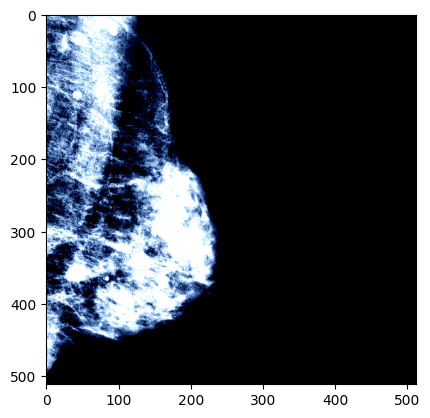

In [108]:
plt.imshow(dst[0]["pixel_values"].permute(1,2,0))

In [112]:
dls = CBISDDSMDataModule(IMAGE_DIR,2)

In [116]:
dl = DataLoader(dst, 2, shuffle=True)

In [123]:
batch = next(iter(dl))

for k,v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [124]:
######

In [ ]:

class SegformerFinetuner(pl.LightningModule):
    
    def __init__(self, id2label, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        
        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}
        
        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512", 
            return_dict=False, 
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )
        
        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")
        
    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return(outputs)
    
    def training_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes, 
                ignore_index=255, 
                reduce_labels=False,
            )
            
            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}
            
            for k,v in metrics.items():
                self.log(k,v)
            
            return(metrics)
        else:
            return({'loss': loss})
    
    def validation_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        
        return({'val_loss': loss})
    
    def validation_epoch_end(self, outputs):
        metrics = self.val_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=255, 
              reduce_labels=False,
          )
        
        avg_val_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]
        
        metrics = {"val_loss": avg_val_loss, "val_mean_iou":val_mean_iou, "val_mean_accuracy":val_mean_accuracy}
        for k,v in metrics.items():
            self.log(k,v)

        return metrics
    
    def test_step(self, batch, batch_nb):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = nn.functional.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
            
        return({'test_loss': loss})
    
    def test_epoch_end(self, outputs):
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes, 
              ignore_index=255, 
              reduce_labels=False,
          )
       
        avg_test_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

         metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}
        
        for k,v in metrics.items():
            self.log(k,v)
        
        return metrics
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)
    
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl